__Regime Discovery__

- Standardize features; run K‑means (k=2–5) and Ward Linkage.
- Select k via elbow and silhouette; do stability checks.
- Profile regimes (means, smiles, timelines); save labels to Parquet.=

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns

__Load the aggregated daily features parquet files__

In [2]:
features_df = pd.read_parquet("features_parquet/", engine="fastparquet")
features_df.head()

,date,ATM_IV,Skew,Curvature,treasury_2y,ticker,year
0,2022-01-03,0.168059,0.062764,0.009883,0.78,QQQ,2022
1,2022-01-04,0.176395,0.093166,0.037454,0.77,QQQ,2022
2,2022-01-05,0.234323,0.090518,0.009621,0.83,QQQ,2022
3,2022-01-06,0.221465,0.096028,0.018208,0.88,QQQ,2022
4,2022-01-07,0.228680,0.092189,0.008344,0.87,QQQ,2022


__Standardize the features__

Clustering is distance-based, so we scale each feature to have mean=0 and std=1.

In [3]:
X = features_df[['ATM_IV', 'Skew', 'Curvature']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
X_scaled[:5]

array([[-1.00757379, -0.01456329,  0.56857909],
       [-0.8668249 ,  1.39565007,  4.26098487],
       [ 0.11125834,  1.27282115,  0.53349113],
       [-0.1058421 ,  1.52840551,  1.68349252],
       [ 0.01597931,  1.3503314 ,  0.36240381]])

__K-means clustering for k=2 to k=5__

We run K-means for different k values, storing inertia (elbow method) and silhouette scores.

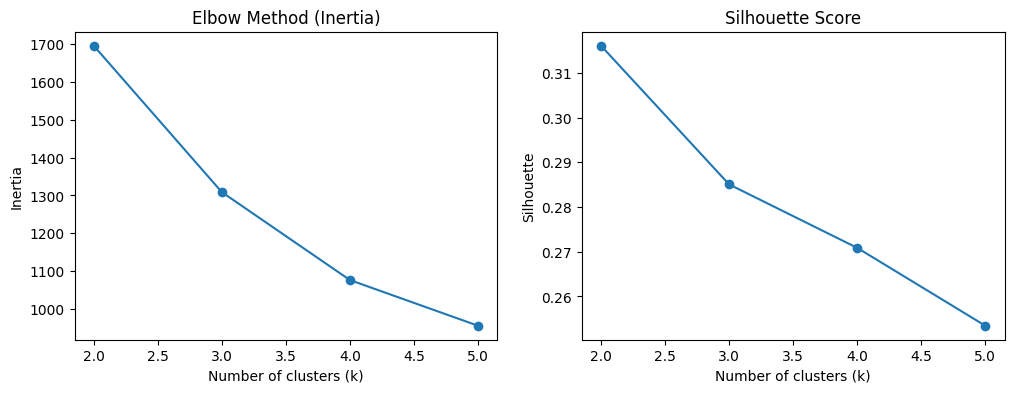

In [5]:
inertias = []
silhouettes = []

K_range = range(2, 6)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# Plot elbow and silhouette
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(K_range, inertias, marker='o')
ax[0].set_title("Elbow Method (Inertia)")
ax[0].set_xlabel("Number of clusters (k)")
ax[0].set_ylabel("Inertia")

ax[1].plot(K_range, silhouettes, marker='o')
ax[1].set_title("Silhouette Score")
ax[1].set_xlabel("Number of clusters (k)")
ax[1].set_ylabel("Silhouette")
plt.show()

Elbow method: Inertia drops sharply until k=3, after which the improvement flattens — suggesting 3 clusters is a reasonable choice.

Silhouette score declines at k=3 and stays relatively stable for k=4–5. This indicates tighter, more separated clusters at k=2, but k=3 may capture more regime nuance despite slightly lower separation.

__Ward linkage hierarchical clustering__

Ward linkage minimizes variance within clusters. We plot a dendrogram to inspect natural splits.

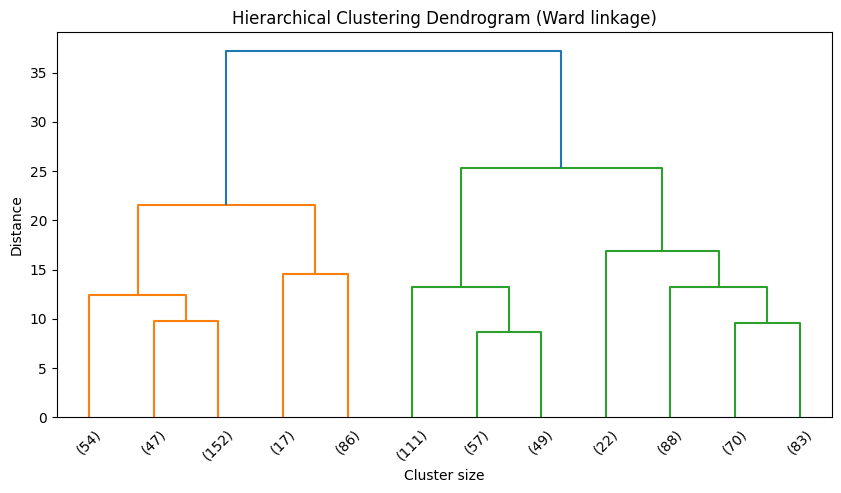

In [6]:
Z = linkage(X_scaled, method='ward')

plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=10.)
plt.title("Hierarchical Clustering Dendrogram (Ward linkage)")
plt.xlabel("Cluster size")
plt.ylabel("Distance")
plt.show()

Shows clear merges at relatively low distances for some groups, with a noticeable jump in merge height when moving from 3 to fewer clusters.

This supports the idea that 3 regimes is a natural split, as cutting the tree at that level balances within‑cluster similarity and between‑cluster separation.

In [7]:
# Based on elbow/silhouette/dendrogram, choose k=3 fir K-means.
k_optimal = 3
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
features_df['Regime_K'] = kmeans_final.fit_predict(X_scaled)

In [8]:
# do same for ward linkage
labels_ward = fcluster(Z, t=3, criterion='maxclust')  # t=3 means force 3 clusters
features_df['Regime_Ward'] = labels_ward

In [9]:
features_df.head()

,date,ATM_IV,Skew,Curvature,treasury_2y,ticker,year,Regime_K,Regime_Ward
0,2022-01-03,0.168059,0.062764,0.009883,0.78,QQQ,2022,1,1
1,2022-01-04,0.176395,0.093166,0.037454,0.77,QQQ,2022,0,1
2,2022-01-05,0.234323,0.090518,0.009621,0.83,QQQ,2022,0,3
3,2022-01-06,0.221465,0.096028,0.018208,0.88,QQQ,2022,0,1
4,2022-01-07,0.228680,0.092189,0.008344,0.87,QQQ,2022,0,3


In [10]:
# K-means labels
labels_kmeans = kmeans_final.labels_

# Internal metrics
print("K-means Silhouette:", silhouette_score(X_scaled, labels_kmeans))
print("Ward Silhouette:", silhouette_score(X_scaled, labels_ward))

print("K-means CH Index:", calinski_harabasz_score(X_scaled, labels_kmeans))
print("Ward CH Index:", calinski_harabasz_score(X_scaled, labels_ward))

print("K-means DB Index:", davies_bouldin_score(X_scaled, labels_kmeans))
print("Ward DB Index:", davies_bouldin_score(X_scaled, labels_ward))

K-means Silhouette: 0.28504981204281005
Ward Silhouette: 0.22665495777904826
K-means CH Index: 381.564922889568
Ward CH Index: 282.0207392378751
K-means DB Index: 1.1683474033403034
Ward DB Index: 1.3322368601840855


- Silhouette score - higher means better separation.
- Calinski–Harabasz index → higher means more distinct clusters.
- Davies–Bouldin index → lower means better separation.

Ward linkage performs better on Silhouette and Davies–Bouldin which indicates more compact, well‑separated regimes.
K‑means performs better on Calinski–Harabasz which indicates, stronger between‑cluster dispersion relative to within‑cluster variance. 

We check stability (cluster assignments consistency while slightly changing the data), by re-running clustering with different seeds and check % of points with same label for both k-means and ward-linkage.
This helps ensure regimes are robust.

In [11]:
def stability_check_bootstrap(X_scaled, k, runs=5, sample_frac=0.8, method='kmeans'):
    n_samples = X_scaled.shape[0]

    # Base labels from full dataset
    if method == 'kmeans':
        base_labels = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X_scaled)
    elif method == 'ward':
        Z_base = linkage(X_scaled, method='ward')
        base_labels = fcluster(Z_base, t=k, criterion='maxclust')

    scores = []
    for _ in range(runs):
        idx = np.random.choice(n_samples, int(sample_frac * n_samples), replace=False)
        X_sample = X_scaled[idx]

        if method == 'kmeans':
            labels_sample = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X_sample)
        elif method == 'ward':
            Z_sample = linkage(X_sample, method='ward')
            labels_sample = fcluster(Z_sample, t=k, criterion='maxclust')

        scores.append(adjusted_rand_score(base_labels[idx], labels_sample))

    return np.mean(scores)

print("K-means bootstrap stability:", stability_check_bootstrap(X_scaled, 3, method='kmeans'))
print("Ward bootstrap stability:", stability_check_bootstrap(X_scaled, 3, method='ward'))


K-means bootstrap stability: 0.924972826119653
Ward bootstrap stability: 0.3532283475677084


K-means produces regime assignments that are more consistent when the dataset changes slightly when compared to Ward Linkage.

            ATM_IV      Skew  Curvature
Regime_K                               
0         0.259603  0.087327   0.010326
1         0.172632  0.048872   0.007384
2         0.262008  0.057734  -0.000489


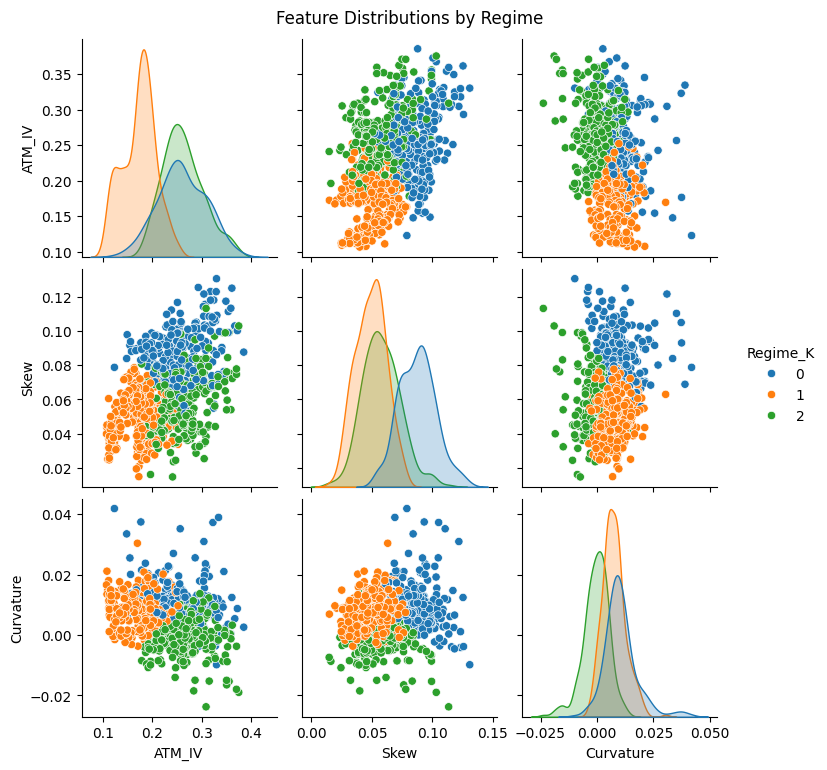

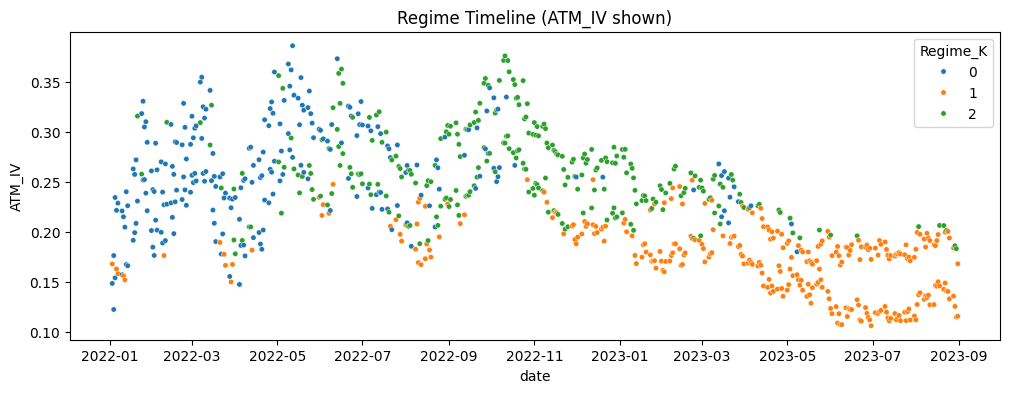

In [12]:
# ============================================
# 8. Profile regimes for K means
# ============================================
# We compute average ATM_IV, Skew, Curvature per regime and plot timelines.
regime_k_profile = features_df.groupby('Regime_K')[['ATM_IV', 'Skew', 'Curvature']].mean()
print(regime_k_profile)

sns.pairplot(features_df, vars=['ATM_IV', 'Skew', 'Curvature'], hue='Regime_K', palette='tab10')
plt.suptitle("Feature Distributions by Regime", y=1.02)
plt.show()

plt.figure(figsize=(12, 4))
sns.scatterplot(data=features_df, x='date', y='ATM_IV', hue='Regime_K', palette='tab10', s=15)
plt.title("Regime Timeline (ATM_IV shown)")
plt.show()

               ATM_IV      Skew  Curvature
Regime_Ward                               
1            0.176690  0.050560   0.007096
2            0.268597  0.054984   0.001626
3            0.263111  0.086701   0.006973


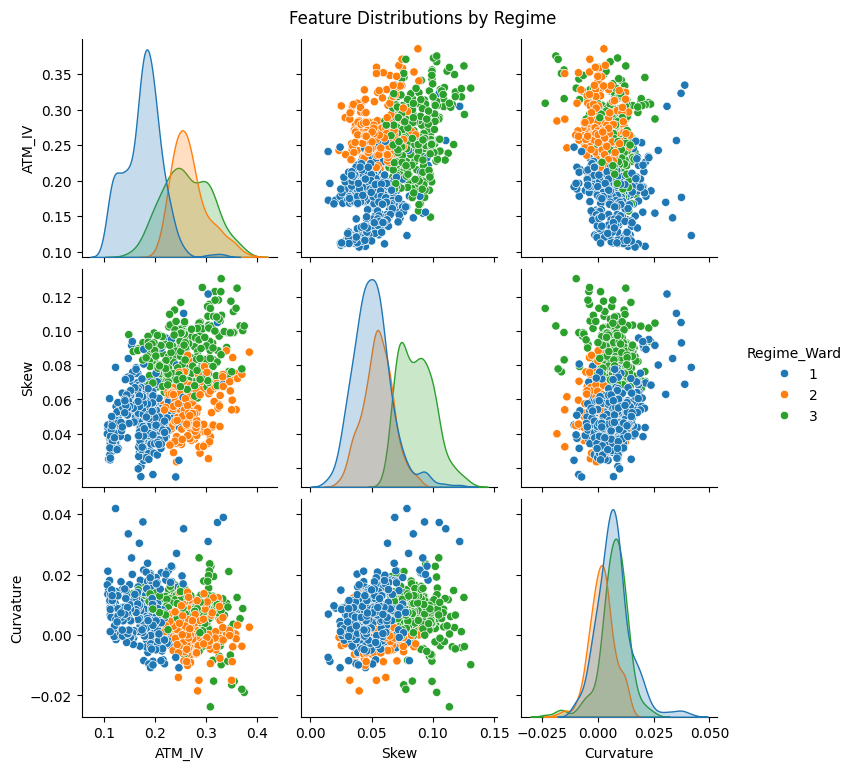

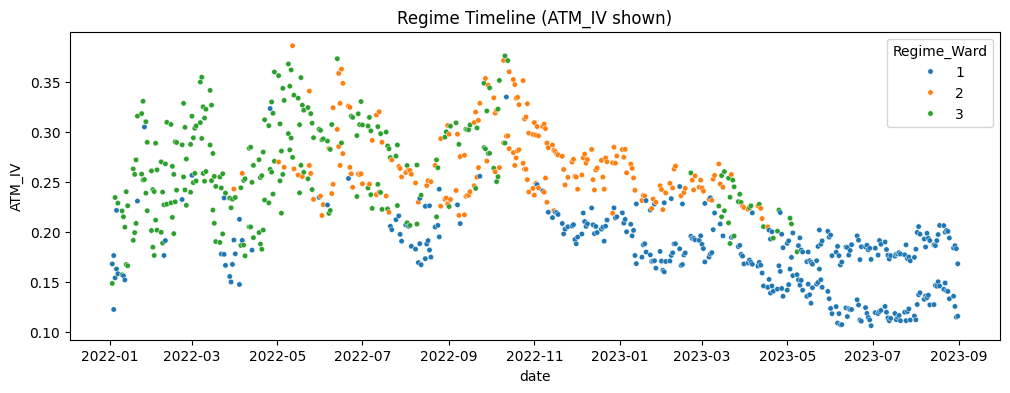

In [13]:
# ============================================
# 8. Profile regimes for Ward linkage
# ============================================
# We compute average ATM_IV, Skew, Curvature per regime and plot timelines.
regime_ward_profile = features_df.groupby('Regime_Ward')[['ATM_IV', 'Skew', 'Curvature']].mean()
print(regime_ward_profile)

sns.pairplot(features_df, vars=['ATM_IV', 'Skew', 'Curvature'], hue='Regime_Ward', palette='tab10')
plt.suptitle("Feature Distributions by Regime", y=1.02)
plt.show()

plt.figure(figsize=(12, 4))
sns.scatterplot(data=features_df, x='date', y='ATM_IV', hue='Regime_Ward', palette='tab10', s=15)
plt.title("Regime Timeline (ATM_IV shown)")
plt.show()

The pair plot shows how ATM_IV, Skew, and Curvature differ across the 3 regimes, with histograms revealing distinct feature ranges per regime and scatter plots showing regime‑specific relationships. The time series plot maps these regimes over time, revealing periods of persistence and transitions. Multiple regimes on the same day occur because clustering is applied to individual observations, which can vary intraday or across instruments, leading to different regime assignments within the same calendar date.

In [14]:
# dropping regime classification generated by ward linkage and using k-means instead
features_df = features_df.drop(columns=['Regime_Ward'])

__Save to Parquet: We persist the dataset with regime labels for downstream modeling.__

In [15]:
features_df.to_parquet("daily_features_with_regimes.parquet", index=False)